In [1]:
from libraries import lib
import torch.nn as nn 
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import numpy.random as npr
import random

class SparseStateVector:
    """
    Container class for dictionary (self.values) with keys of integer states
    and values being complex amplitude of psi
    """
    def __init__(self):
        self.values = {}
        self.normalized = False

    def TFIM_multiply(psi, N, J, Gamma):
        """
        Returns new sparse vector representing H|psi>
        """
        prod = SparseStateVector()
        for state in psi.values:
            jtotal = 0
            for site in range(N - 1):
                jtotal += J if ((state >> site) ^ (state >> site + 1)) & 1 else -J
            jtotal += J if ((state >> (N - 1)) ^ (state >> 0)) & 1 else -J 
            prod.values[state] = jtotal * psi.values[state]
        
        for state in psi.values:
            for site in range(N):
                flipped_state = state ^ (1 << site)
                prod.values[flipped_state] = prod.values.get(flipped_state, 0) - Gamma * psi.values[state]
        return prod

    def inner_product(v1, v2):
        """
        Returns <v1|v2> for two SparseStateVectors
        """
        prod = 0
        for s in v1.values:
            if s in v2.values:
                prod += torch.conj(v1.values[s]) * v2.values[s]
        return prod

    def TFIM_expectation_from_sparse(psi, N, J, Gamma):
        """
        Returns <psi|H|psi>/<psi|psi> for SparseStateVector psi
        """
        # do H|psi> then <psi| (H|psi>)
        hpsi = SparseStateVector.TFIM_multiply(psi, N, J, Gamma)
        exp = SparseStateVector.inner_product(psi, hpsi)
        if not psi.normalized:
            mag2 = SparseStateVector.inner_product(psi, psi)
            return (exp / mag2).real
        return exp.real

    def normalize(self):
        """
        Normalizes values
        """
        mag = sum(abs(self.values[s]) ** 2 for s in self.values) ** 0.5
        for s in self.values:
            self.values[s] = self.values[s] / mag
        self.normalized = True

    def to_prob_distribution(self, N):
        """
        Returns 1D list representing real probability distribution
        """
        if not self.normalized:
            mag2 = sum(abs(self.values[s]) ** 2 for s in self.values)
            return [(abs(self.values.get(s, 0)) ** 2 / mag2).item() for s in range(0, 2 ** N)]
        return [abs(self.values.get(s, 0)) ** 2 for s in range(0, 2 ** N)]
    
    def to_dense_vector(self, N):
        """
        Returns 1D list of dense representation
        """
        if not self.normalized:
            mag = sum(abs(self.values[s]) ** 2 for s in self.values) ** 0.5
            return [(self.values.get(s, 0) / mag).item() for s in range(0, 2 ** N)]
        return [self.values.get(s, 0).item() for s in range(0, 2 ** N)]

class UniformNeuralState(SparseStateVector):
    def __init__(self, N, model, output_to_psi, num_samples, informed = False):
        """
        Initializes sparse vector values

        Args:
            N (int): number of qubits
            model: torch model representing psi(x), which returns complex amplitude given integer state
            output_to_psi (function): takes in output of model to compute complex amplitude
            num_samples (int): number of unique integer samples to take
            informed (bool): whether to guarantee sample first and last states
        """
        super().__init__()
        self.samples = num_samples
        self.distribution = {}
        self.list = []
        self.nn_output = {}
        def psi(x):
            tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
            nn_output = model(tens)
            return output_to_psi(nn_output)[0], nn_output[0]
        if num_samples >= 2 ** N:
            for state in range(2 ** N):
                self.distribution[state] = 1
                self.list.append(state)
                self.values[state], self.nn_output[state] = psi(state)
        else:
            sampled_states = set()
            if informed: 
                sampled_states.add(0)
                self.distribution[0] = self.distribution.get(0, 0) + 1
                self.list.append(0)
                sampled_states.add(2 ** N - 1)
                self.distribution[2 ** N - 1] = self.distribution.get(2 ** N - 1, 0) + 1
                self.list.append(2 ** N - 1)
                num_samples = num_samples - 2
            for _ in range(num_samples):
                x = random.getrandbits(N)
                while x in sampled_states:
                    x = random.getrandbits(N)
                sampled_states.add(x)
                self.distribution[x] = self.distribution.get(x, 0) + 1
                self.list.append(x)
            for state in sampled_states:
                self.values[state], self.nn_output[state] = psi(state)

class MHNeuralState(SparseStateVector):
    def __init__(self, N, model, output_to_psi, x_func, x0, num_samples, burnin = 0, lag = 0, informed = False):
        """
        Initializes distribution of samples and vector values

        Args:
            N (int): number of qubits
            model: torch model representing psi(x), which returns complex amplitude given integer state
            output_to_psi (function): takes in output of model to compute complex amplitude
            x_func (function): takes in state x and generates proposal x*
            x0 (int): intger state to begin sampling
            num_samples (int): number of proposal x* generated
            burnin (int): number of samples to throw away before accepting first sample
            lag (int): number of samples to throw away in-between accepting samples
            informed (bool): whether to guarantee sample first and last states
        """
        # uses arbitrary x_func for MH sampling
        super().__init__()
        self.distribution = {}
        self.list = []
        self.nn_output = {}
        self.samples = num_samples
        def psi(x):
            tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
            nn_output = model(tens)
            return output_to_psi(nn_output)[0], nn_output[0]
        num_uniform = burnin + num_samples * (lag + 1)
        rand_uniform = npr.uniform(0, 1, num_uniform)
        index = 0
        if informed: 
            self.values[0], self.nn_output[0] = psi(0)
            self.values[2 ** N - 1], self.nn_output = psi(2 ** N - 1)
            self.distribution[0] = 1
            self.list.append(0)
            self.distribution[2 ** N - 1] = 1
            self.list.append(2 ** N - 1)
            num_samples = num_samples - 2
        x = x0
        psi_val, nn_val = psi(x)
        self.values[x] = psi_val
        self.nn_output[x] = nn_val
        for _ in range(burnin):
            new_x = x_func(x)
            new_psi_val = self.values[new_x] if new_x in self.values else psi(new_x)[0]
            ratio = abs(new_psi_val) ** 2 / abs(psi_val) ** 2
            if ratio > 1 or ratio > rand_uniform[index]:
                x = new_x
                psi_val = new_psi_val
            index += 1
        for _ in range(num_samples):
            for _ in range(lag):
                new_x = x_func(x)
                new_psi_val = self.values[new_x] if new_x in self.values else psi(new_x)[0]
                ratio = abs(new_psi_val) ** 2 / abs(psi_val) ** 2
                if ratio > 1 or ratio > rand_uniform[index]:
                    x = new_x
                    psi_val = new_psi_val
                index += 1
            new_x = x_func(x)
            if new_x in self.values: new_psi_val, new_nn_val = self.values[new_x], self.nn_output[new_x]
            else: new_psi_val, new_nn_val = psi(new_x)
            ratio = abs(new_psi_val) ** 2 / abs(psi_val) ** 2
            if ratio > 1 or ratio > rand_uniform[index]:
                self.distribution[new_x] = self.distribution.get(new_x, 0) + 1
                self.list.append(new_x)
                x = new_x 
                psi_val = new_psi_val 
            else: 
                self.distribution[x] = self.distribution.get(x, 0) + 1
                self.list.append(x)
            self.values[new_x] = new_psi_val
            self.nn_output[new_x] = new_nn_val
            index += 1

    # def distribution_to_list(self):
    #     """
    #     Returns list of sampled states with repetition
    #     """
    #     return [state for state in self.distribution for _ in range(self.distribution[state])]

In [3]:
def amp_phase(nn_output):
    return nn_output[:, 0] * torch.exp(1.j * 2 * np.pi * nn_output[:, 1])
def log_amp_phase(nn_output):
    return torch.exp(nn_output[:, 0] + 1.j * 2 * np.pi * nn_output[:, 1])
c = 1e-8
def log_amp_phase_c(nn_output):
    return (torch.exp(nn_output[:, 0]) - c) * torch.exp(1.j * 2 * np.pi * nn_output[:, 1]) 
def bitflip_x(x, N, flips):
    new_x = x
    for _ in range(flips):
        new_x = x ^ (1 << npr.randint(0, N))
    return new_x

In [4]:
N = 4; J = 1; Gamma = 1

In [5]:
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.Sigmoid(),
    nn.Linear(5 * N, 2),
)

In [6]:
model(torch.tensor([lib.generate_state_array(0, N)], dtype = torch.float32))

tensor([[0.0133, 0.0996]], grad_fn=<AddmmBackward0>)

In [7]:
log_amp_phase_c(model(torch.tensor([lib.generate_state_array(0, N)], dtype = torch.float32)))[0]

tensor(0.8212+0.5938j, grad_fn=<SelectBackward0>)

In [8]:
num_samples = 200
mhn = MHNeuralState(N, model, log_amp_phase_c, lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)

In [9]:
len(mhn.values)

16

In [10]:
mhn.list

[12,
 8,
 0,
 1,
 5,
 13,
 5,
 1,
 9,
 1,
 0,
 8,
 10,
 11,
 15,
 13,
 5,
 7,
 3,
 7,
 15,
 13,
 12,
 8,
 10,
 2,
 10,
 14,
 10,
 14,
 10,
 2,
 3,
 11,
 3,
 1,
 0,
 4,
 5,
 13,
 12,
 14,
 15,
 13,
 5,
 13,
 12,
 13,
 9,
 13,
 5,
 1,
 0,
 1,
 3,
 2,
 6,
 7,
 3,
 11,
 10,
 2,
 6,
 4,
 5,
 13,
 12,
 4,
 12,
 8,
 12,
 4,
 4,
 5,
 4,
 4,
 5,
 7,
 5,
 7,
 5,
 7,
 6,
 4,
 6,
 2,
 10,
 14,
 15,
 14,
 6,
 4,
 4,
 6,
 14,
 15,
 7,
 15,
 7,
 5,
 7,
 7,
 5,
 13,
 15,
 13,
 9,
 13,
 5,
 7,
 6,
 7,
 6,
 14,
 15,
 13,
 12,
 13,
 15,
 11,
 10,
 8,
 12,
 8,
 10,
 8,
 10,
 2,
 0,
 4,
 0,
 2,
 3,
 7,
 15,
 14,
 6,
 14,
 15,
 11,
 3,
 11,
 10,
 8,
 10,
 8,
 0,
 4,
 0,
 8,
 0,
 2,
 0,
 8,
 0,
 1,
 9,
 11,
 15,
 13,
 15,
 14,
 10,
 11,
 3,
 2,
 0,
 2,
 6,
 2,
 10,
 11,
 9,
 13,
 15,
 13,
 9,
 13,
 9,
 13,
 12,
 13,
 9,
 8,
 9,
 8,
 0,
 1,
 9,
 11,
 9,
 8,
 10,
 2,
 0,
 4,
 5,
 13,
 15,
 7]

In [11]:
np.log(1.j)

np.complex128(1.5707963267948966j)

In [12]:
# only for nn_output = (log(amp), phase)
def generate_eloc_list(sampled_vector, N, J, Gamma, model):
    nn_output_calcs = {}
    res = 0
    total_amp = 0
    def model_to_output(x):
        if x in sampled_vector.nn_output:
            return sampled_vector.nn_output[x]
        if x in nn_output_calcs:
            return nn_output_calcs[x]
        tens = torch.tensor([lib.generate_state_array(x, N)], dtype = torch.float32)
        output = model(tens)[0]
        nn_output_calcs[x] = output
        return output

    eloc_values = []
    for basis_state in sampled_vector.list:
        eloc = 0
        output = model_to_output(basis_state)
        for adjacency in lib.generate_adjacencies(basis_state, N):
            output_prime = model_to_output(adjacency)
            # eloc += lib.calc_H_elem(N, J, Gamma, basis_state, adjacency) * (torch.exp(output_prime[0]) - c) / (torch.exp(output[0]) - c) * torch.exp(1.j * 2 * np.pi * (output_prime[1] - output[1]))
            eloc += lib.calc_H_elem(N, J, Gamma, basis_state, adjacency) * torch.exp(output_prime[0] - output[0] + 1.j * 2 * np.pi * (output_prime[1] - output[1]))
        # eloc += lib.calc_H_elem(N, J, Gamma, basis_state, basis_state)
        # state_amp = abs(sampled_vector.values[basis_state]) ** 2
        # total_amp += state_amp
        # res += state_amp * eloc
        eloc_values.append(eloc)
        # for _ in range(sampled_vector.distribution[basis_state]):
        #     eloc_values.append(eloc)
    return eloc_values
    # return (res / total_amp).real

In [13]:
ustate = UniformNeuralState(N, model, log_amp_phase, 2 ** N)
print(SparseStateVector.TFIM_expectation_from_sparse(ustate, N, J, Gamma).item())
print(torch.tensor(generate_eloc_list(ustate, N, J, Gamma, model)).mean().item())
print(lib.TFIM_expectation_using_locals(ustate, N, J, Gamma, model, log_amp_phase).item())

-3.9282782077789307
(-3.9365696907043457-0.005714223720133305j)
-3.9282782077789307


In [14]:
sum(generate_eloc_list(ustate, 4, J, Gamma, model)).conj()

tensor(-62.9851+0.0914j, grad_fn=<ConjBackward0>)

In [15]:
mhstate = MHNeuralState(N, model, log_amp_phase, lambda x : bitflip_x(x, N, 1), 2 ** (N - 1), 10000)
print(torch.tensor(generate_eloc_list(mhstate, N, J, Gamma, model)).mean().item())
print(lib.TFIM_expectation_using_locals(mhstate, N, J, Gamma, model, log_amp_phase).item())

(-3.9123332500457764-0.00748947449028492j)
-3.928278923034668


In [16]:
N = 20; J = 1; Gamma = 10

In [17]:
num_epochs = 100 + 1
data_rate = 1
num_samples = 500

In [18]:
torch.tensor([1, 2, 3]) * torch.tensor([2, 3, 4])

tensor([ 2,  6, 12])

In [20]:
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.SiLU(),
    nn.Linear(5 * N, 2),
    nn.SiLU(),
) # logsig logsig is good, relu bad
# model = nn.Sequential(
#     nn.Linear(N, 5 * N),
#     nn.Sigmoid(),
#     nn.Linear(5 * N, 2),
#     nn.Sigmoid()
# ) 
epochs = []
energy_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
for epoch in range(num_epochs):
    mh_state = MHNeuralState(N, model, log_amp_phase, lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
    log_psi_conj = [torch.log(mh_state.values[x]).conj() for x in mh_state.list]
    # log_psi_conj = [torch.log(model(torch.tensor(lib.generate_state_array(x, N), dtype=torch.float32))).conj() for x in mh_state.list]
    eloc_list = torch.tensor(generate_eloc_list(mh_state, N, J, Gamma, model)).detach()
    energy_list = eloc_list - eloc_list.mean()
    loss = sum((log_psi_conj[i] * energy_list[i]).real for i in range(len(mh_state.list))) / len(mh_state.list)
    energy = eloc_list.mean()
    # loss = generate_eloc_list(MHNeuralState(N, model, log_amp_phase,
    #                                           lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples),
    #                                           N, J, Gamma, model)
    # loss = lib.TFIM_expectation_using_locals(MHNeuralState(N, model, log_amp_phase, 
    #                                                        lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples), 
    #                                                        N, J, Gamma, model, log_amp_phase) # this works Gamma = 10
    # print(loss, energy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        energy_data.append(energy.item().real)
        epochs.append(epoch)
    if epoch % 1 == 0:
        print(epoch, energy, loss.item())
print(energy_data[-1])
print(min(energy_data))

0 tensor(-198.7153-0.7261j) 0.6872391700744629
1 tensor(-194.8194+1.6971j) 5.712592601776123
2 tensor(-200.6506-0.2730j) 0.1674526333808899
3 tensor(-200.9039-0.0131j) 0.17438724637031555
4 tensor(-200.3995+0.0043j) 0.04298098385334015
5 tensor(-197.2028+0.0008j) 5.154326915740967
6 tensor(-200.9219-0.0688j) 0.009371206164360046
7 tensor(-200.4215-0.0251j) 0.0016291580395773053
8 tensor(-199.8148+0.0042j) 0.0004513357998803258
9 tensor(-200.6958+0.0094j) -7.186979928519577e-06
10 tensor(-199.2141-0.0080j) 0.001492127077654004
11 tensor(-200.7175-0.0400j) 0.0027723805978894234
12 tensor(-200.3516+0.0098j) 3.9270849811146036e-05
13 tensor(-199.2219-0.0068j) 0.0018787762382999063
14 tensor(-199.6713-0.0068j) 0.0005070234183222055
15 tensor(-200.8333-0.1088j) 0.010991016402840614
16 tensor(-200.1907+0.0117j) 5.4968870244920254e-05
17 tensor(-199.4559+0.0034j) 1.528698339825496e-05
18 tensor(-200.7437-0.0016j) 0.0001280432043131441
19 tensor(-199.7758+0.0143j) 1.906110014715523e-06
20 tenso

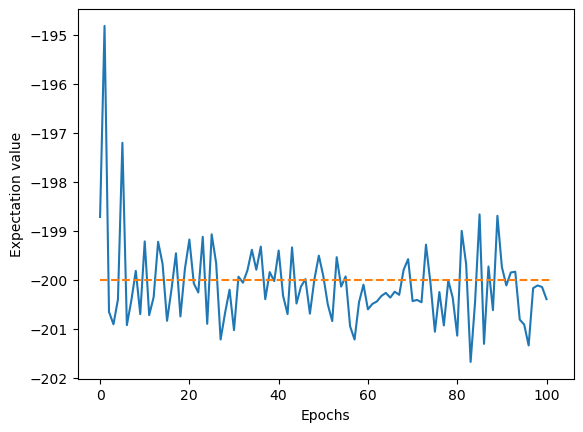

In [21]:
# ground state energy about -10N
plt.plot(epochs, energy_data)
plt.plot([0, num_epochs], [-10 * N] * 2, linestyle = '--')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()

In [22]:
Gamma = 0.1

In [23]:
num_epochs = 100 + 1
data_rate = 1
num_samples = 500

In [24]:
# model = nn.Sequential(
#     nn.Linear(N, 5 * N),
#     nn.SiLU(),
#     nn.Linear(5 * N, 2),
#     nn.SiLU(),
# )
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.LogSigmoid(),
    nn.Linear(5 * N, 2),
    nn.LogSigmoid()
) # relu bad, silu ??, logsig good, stuff often gets stuck at 16?
epochs = []
energy_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
for epoch in range(num_epochs):
    mh_state = MHNeuralState(N, model, log_amp_phase, lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
    log_psi_conj = [torch.log(mh_state.values[x]).conj() for x in mh_state.list]
    eloc_list = torch.tensor(generate_eloc_list(mh_state, N, J, Gamma, model)).detach()
    energy_list = eloc_list - eloc_list.mean()
    loss = sum((log_psi_conj[i] * energy_list[i]).real for i in range(len(mh_state.list))) / len(mh_state.list)
    energy = eloc_list.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        energy_data.append(energy.item().real)
        epochs.append(epoch)
    if epoch % 1 == 0:
        print(epoch, energy, loss.item())
print(energy_data[-1])
print(min(energy_data))

0 tensor(-2.8095-0.0038j) -0.007019239477813244
1 tensor(-1.8995-0.0018j) 0.10338471084833145
2 tensor(-1.1901-0.0037j) 0.02200278639793396
3 tensor(-3.2754-0.0007j) -0.033401500433683395
4 tensor(-1.3193-0.0020j) -0.004070603288710117
5 tensor(-1.4596+0.0028j) 0.007651335559785366
6 tensor(-1.0406-0.0052j) 0.15409529209136963
7 tensor(-2.6219+0.0050j) 0.012222833931446075
8 tensor(-2.6468+0.0006j) 0.0016544893151149154
9 tensor(-1.7677-0.0079j) 0.007222251035273075
10 tensor(-1.8144+0.0018j) -0.00024629887775518
11 tensor(-1.2951+0.0008j) -0.004374893847852945
12 tensor(-3.0714-0.0029j) 0.0015657816547900438
13 tensor(-3.3509+0.0018j) -0.002299693413078785
14 tensor(-2.4719-0.0013j) -0.008599075488746166
15 tensor(-2.2795-0.0058j) 0.0080456817522645
16 tensor(-2.7670+0.0030j) 0.002654855139553547
17 tensor(-1.0716+0.0014j) 0.014803595840930939
18 tensor(-2.7516+0.0008j) -0.0009163077338598669
19 tensor(-2.6322+0.0017j) 0.0029531402979046106
20 tensor(-2.2878-0.0004j) -0.00095255934866

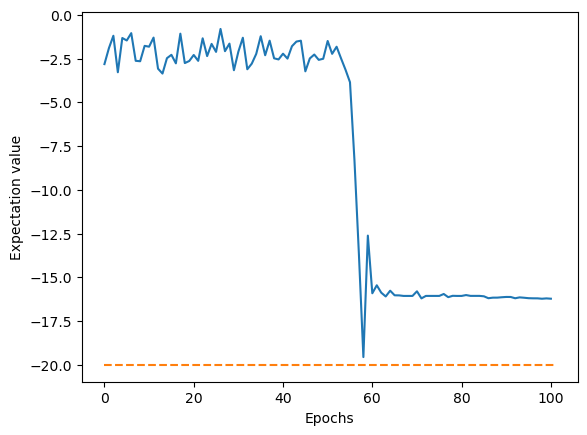

In [25]:
# ground state energy about -N
plt.plot(epochs, energy_data)
plt.plot([0, num_epochs], [-N] * 2, linestyle = '--')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()

In [26]:
Gamma = 1

In [27]:
num_epochs = 100 + 1
data_rate = 1
num_samples = 500

In [28]:
# model = nn.Sequential(
#     nn.Linear(N, 5 * N),
#     nn.LogSigmoid(),
#     nn.Linear(5 * N, 2),
#     nn.LogSigmoid(),
# )
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    nn.SiLU(),
    nn.Linear(5 * N, 2),
    nn.SiLU(),
)
# silu got to -23 1st run, second run -25 and logsig only -20 at 250 samples
epochs = []
energy_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
for epoch in range(num_epochs):
    mh_state = MHNeuralState(N, model, log_amp_phase, lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
    log_psi_conj = [torch.log(mh_state.values[x]).conj() for x in mh_state.list]
    eloc_list = torch.tensor(generate_eloc_list(mh_state, N, J, Gamma, model)).detach()
    energy_list = eloc_list - eloc_list.mean()
    loss = sum((log_psi_conj[i] * energy_list[i]).real for i in range(len(mh_state.list))) / len(mh_state.list)
    energy = eloc_list.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        energy_data.append(energy.item().real)
        epochs.append(epoch)
    if epoch % 1 == 0:
        print(epoch, energy, loss.item())
print(energy_data[-1])
print(min(energy_data))

0 tensor(-19.2354+0.0686j) 0.01177334226667881
1 tensor(-19.2943+0.0650j) 0.6235940456390381
2 tensor(-19.7353+0.2556j) 0.25168097019195557
3 tensor(-20.3645-0.0150j) 0.12344926595687866
4 tensor(-20.4276-0.2426j) 0.04695882275700569
5 tensor(-20.6469+0.1489j) 0.11952574551105499
6 tensor(-19.5508+0.0613j) 0.02802441082894802
7 tensor(-20.7025+0.0068j) -0.006455466151237488
8 tensor(-20.1496-0.0249j) -0.10259592533111572
9 tensor(-19.9661+0.0284j) 0.08228837698698044
10 tensor(-20.9398+0.0144j) -0.32159969210624695
11 tensor(-21.2523-0.0018j) -0.14658717811107635
12 tensor(-20.5649+0.0210j) -0.20934343338012695
13 tensor(-20.1427+0.0014j) -0.418850839138031
14 tensor(-20.6300-0.0028j) 0.6765731573104858
15 tensor(-20.0693-0.0019j) -0.07774478942155838
16 tensor(-20.5528-0.0925j) -0.049861472100019455
17 tensor(-21.5382-0.0400j) 0.7570882439613342
18 tensor(-21.8940-0.0130j) 2.2119812965393066
19 tensor(-21.8708+0.0485j) -0.463388592004776
20 tensor(-22.2450-0.0222j) 0.10800167918205261

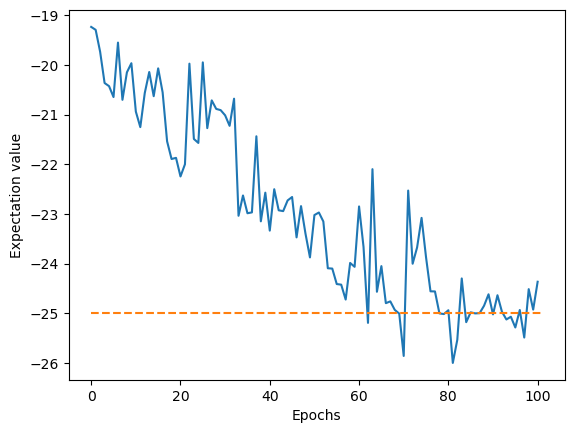

In [30]:
# ground state energy about -1.25 * N
plt.plot(epochs, energy_data)
plt.plot([0, num_epochs], [-1.25 * N] * 2, linestyle = '--')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()

In [31]:
# def logcosh(x, clip_max=1e20): # have to clip this to avoid infinity, somehow infinity divide 2 results in a nan in jax
#     sgn_x = -2 * jnp.signbit(x.real) + 1
#     x = x * sgn_x
#     return jnp.clip(x + jnp.log1p(jnp.exp(-2.0 * x)) - jnp.log(2.0), -clip_max, clip_max)
class LogCosh(nn.Module):
    def __init__(self):
        super(LogCosh, self).__init__()
    def forward(self, x, clip_max = 1e20):
        sgn_x = -2 * torch.signbit(x.real) + 1
        temp = x * sgn_x
        return torch.clamp(temp + torch.log1p(torch.exp(-2.0 * temp)) - np.log(2.0), min=-clip_max, max=clip_max)

In [32]:
Gamma = 10
num_samples = 150

In [33]:
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    LogCosh(),
    nn.Linear(5 * N, 2),
    nn.SiLU()
)
epochs = []
energy_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
for epoch in range(num_epochs):
    mh_state = MHNeuralState(N, model, log_amp_phase, lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
    log_psi_conj = [torch.log(mh_state.values[x]).conj() for x in mh_state.list]
    eloc_list = torch.tensor(generate_eloc_list(mh_state, N, J, Gamma, model)).detach()
    energy_list = eloc_list - eloc_list.mean()
    loss = sum((log_psi_conj[i] * energy_list[i]).real for i in range(len(mh_state.list))) / len(mh_state.list)
    energy = eloc_list.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        energy_data.append(energy.item().real)
        epochs.append(epoch)
    if epoch % 1 == 0:
        print(epoch, energy, loss.item())
print(energy_data[-1])
print(min(energy_data))

0 tensor(-196.9463+1.0696j) 0.8004797697067261
1 tensor(-154.9856-2.5598j) 17.679513931274414
2 tensor(-199.4933+0.j) 0.0
3 tensor(-199.5200+0.j) 0.0
4 tensor(-200.5333+0.j) 0.0
5 tensor(-200.2133+0.j) 0.0
6 tensor(-202.1333+0.j) 0.0
7 tensor(-201.9467+0.j) 0.0
8 tensor(-201.2800+0.j) 0.0
9 tensor(-199.9200+0.j) 0.0
10 tensor(-200.1600+0.j) 0.0
11 tensor(-203.0667+0.j) 0.0
12 tensor(-200.2667+0.j) 0.0
13 tensor(-200.9867+0.j) 0.0
14 tensor(-200.+0.j) 0.0
15 tensor(-200.3733+0.j) 0.0
16 tensor(-200.1333+0.j) 0.0
17 tensor(-200.7467+0.j) 0.0
18 tensor(-199.9467+0.j) 0.0
19 tensor(-198.9600+0.j) 0.0
20 tensor(-198.9867+0.j) 0.0
21 tensor(-201.1200+0.j) 0.0
22 tensor(-200.6667+0.j) 0.0
23 tensor(-200.6400+0.j) 0.0
24 tensor(-199.9200+0.j) 0.0
25 tensor(-200.9867+0.j) 0.0
26 tensor(-199.8400+0.j) 0.0
27 tensor(-201.0400+0.j) 0.0
28 tensor(-201.3067+0.j) 0.0
29 tensor(-199.7333+0.j) 0.0
30 tensor(-201.2267+0.j) 0.0
31 tensor(-200.9333+0.j) 0.0
32 tensor(-200.8800+0.j) 0.0
33 tensor(-199.5733

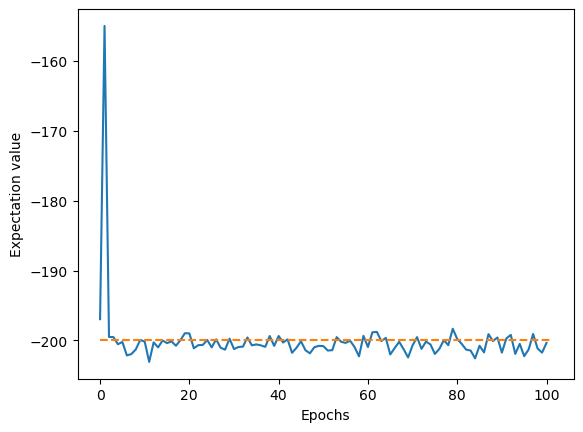

In [34]:
# ground state energy about -10 * N
plt.plot(epochs, energy_data)
plt.plot([0, num_epochs], [-10 * N] * 2, linestyle = '--')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()

In [35]:
Gamma = 0.1
num_samples = 150

In [36]:
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    LogCosh(),
    nn.Linear(5 * N, 2),
) 
epochs = []
energy_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
for epoch in range(num_epochs):
    mh_state = MHNeuralState(N, model, log_amp_phase, lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
    log_psi_conj = [torch.log(mh_state.values[x]).conj() for x in mh_state.list]
    eloc_list = torch.tensor(generate_eloc_list(mh_state, N, J, Gamma, model)).detach()
    energy_list = eloc_list - eloc_list.mean()
    loss = sum((log_psi_conj[i] * energy_list[i]).real for i in range(len(mh_state.list))) / len(mh_state.list)
    energy = eloc_list.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        energy_data.append(energy.item().real)
        epochs.append(epoch)
    if epoch % 1 == 0:
        print(epoch, energy, loss.item())
print(energy_data[-1])
print(min(energy_data))

0 tensor(-3.2935+0.0254j) -0.04025225713849068
1 tensor(-1.6780+0.0019j) 0.04013833403587341
2 tensor(-3.6713-0.0077j) -0.5252814292907715
3 tensor(-6.0454+0.1222j) -1.6131186485290527
4 tensor(-7.6047-0.4566j) -1.843111515045166
5 tensor(-32710.2129-46174.2344j) -31827.2734375
6 tensor(nan+nanj) nan
7 tensor(nan+nanj) nan
8 tensor(nan+nanj) nan
9 tensor(nan+nanj) nan
10 tensor(nan+nanj) nan
11 tensor(nan+nanj) nan
12 tensor(nan+nanj) nan
13 tensor(nan+nanj) nan
14 tensor(nan+nanj) nan
15 tensor(nan+nanj) nan
16 tensor(nan+nanj) nan
17 tensor(nan+nanj) nan
18 tensor(nan+nanj) nan
19 tensor(nan+nanj) nan
20 tensor(nan+nanj) nan
21 tensor(nan+nanj) nan
22 tensor(nan+nanj) nan
23 tensor(nan+nanj) nan
24 tensor(nan+nanj) nan
25 tensor(nan+nanj) nan
26 tensor(nan+nanj) nan
27 tensor(nan+nanj) nan
28 tensor(nan+nanj) nan
29 tensor(nan+nanj) nan
30 tensor(nan+nanj) nan
31 tensor(nan+nanj) nan
32 tensor(nan+nanj) nan
33 tensor(nan+nanj) nan
34 tensor(nan+nanj) nan
35 tensor(nan+nanj) nan
36 te

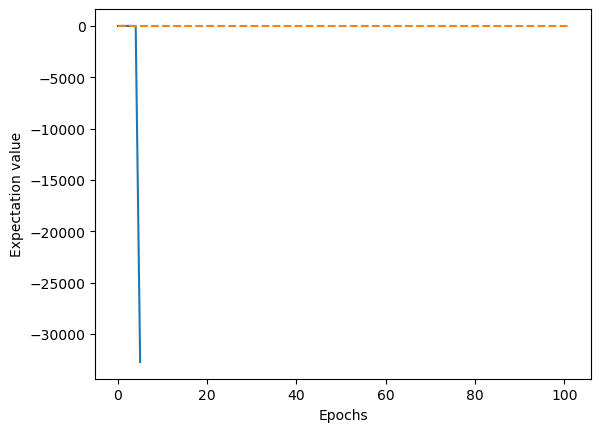

In [37]:
# ground state energy about -N
plt.plot(epochs, energy_data)
plt.plot([0, num_epochs], [-N] * 2, linestyle = '--')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()

In [38]:
Gamma = 1
num_samples = 500

In [39]:
model = nn.Sequential(
    nn.Linear(N, 5 * N),
    LogCosh(),
    nn.Linear(5 * N, 2),
    nn.SiLU()
)
epochs = []
energy_data = []
optimizer = torch.optim.SGD(model.parameters(), lr = 1)
for epoch in range(num_epochs):
    mh_state = MHNeuralState(N, model, log_amp_phase, lambda x: bitflip_x(x, N, 1), 2 ** (N - 1), num_samples)
    log_psi_conj = [torch.log(mh_state.values[x]).conj() for x in mh_state.list]
    eloc_list = torch.tensor(generate_eloc_list(mh_state, N, J, Gamma, model)).detach()
    energy_list = eloc_list - eloc_list.mean()
    loss = sum((log_psi_conj[i] * energy_list[i]).real for i in range(len(mh_state.list))) / len(mh_state.list)
    energy = eloc_list.mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        energy_data.append(energy.item().real)
        epochs.append(epoch)
    if epoch % 1 == 0:
        print(epoch, energy, loss.item())
print(energy_data[-1])
print(min(energy_data))

0 tensor(-19.7779-0.0637j) 0.062334369868040085
1 tensor(-20.1899-0.0101j) 0.03888242691755295
2 tensor(-19.7568+0.0654j) -0.0559387244284153
3 tensor(-19.1336+0.0229j) 0.008944995701313019
4 tensor(-21.0561-0.0554j) -0.04710308462381363
5 tensor(-19.9691+0.0014j) -0.08519443869590759
6 tensor(-20.1587-0.0005j) -0.04737232252955437
7 tensor(-19.1277-0.0001j) -0.18864139914512634
8 tensor(-20.4390-0.0158j) -0.17227500677108765
9 tensor(-20.5324-0.0399j) -0.10475420951843262
10 tensor(-19.7321+0.0211j) -0.12588250637054443
11 tensor(-21.4040+0.0223j) -0.4846045672893524
12 tensor(-20.7896-0.0080j) -0.5445228219032288
13 tensor(-21.1644+0.0010j) -0.6630342602729797
14 tensor(-22.2776+0.1226j) 2.8723011016845703
15 tensor(-16.5357-0.0258j) 1.2357335090637207
16 tensor(-19.3304+0.0004j) -0.0074479952454566956
17 tensor(-19.3735-0.0390j) -0.20259788632392883
18 tensor(-20.5375-0.0892j) -0.18833807110786438
19 tensor(-20.4509-0.0183j) -0.13977369666099548
20 tensor(-21.4798-0.0369j) -0.767395

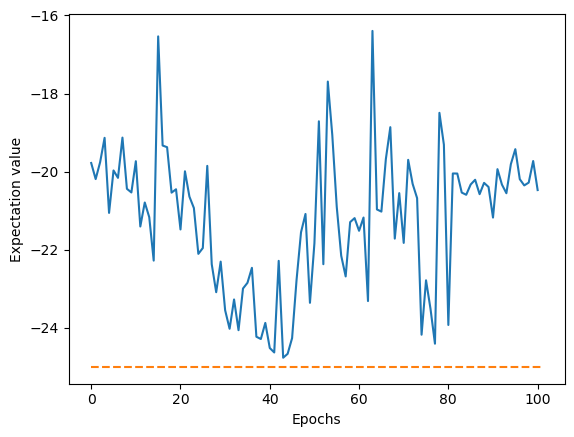

In [40]:
# ground state energy about -1.25 * N
plt.plot(epochs, energy_data)
plt.plot([0, num_epochs], [-1.25 * N] * 2, linestyle = '--')
plt.xlabel('Epochs')
plt.ylabel('Expectation value')
plt.show()